# QSP Notebook: Dose Table Tutorial

*Written by Sarah Minucci, Scientist, ABS (2024)*

In this tutorial we will update the model file, parameter table, and dose table to simulate different doses and dose regimens.

* Single & multiple doses (same dose, or loading dose)
* New route
* New molecule

# Example Model

<div>
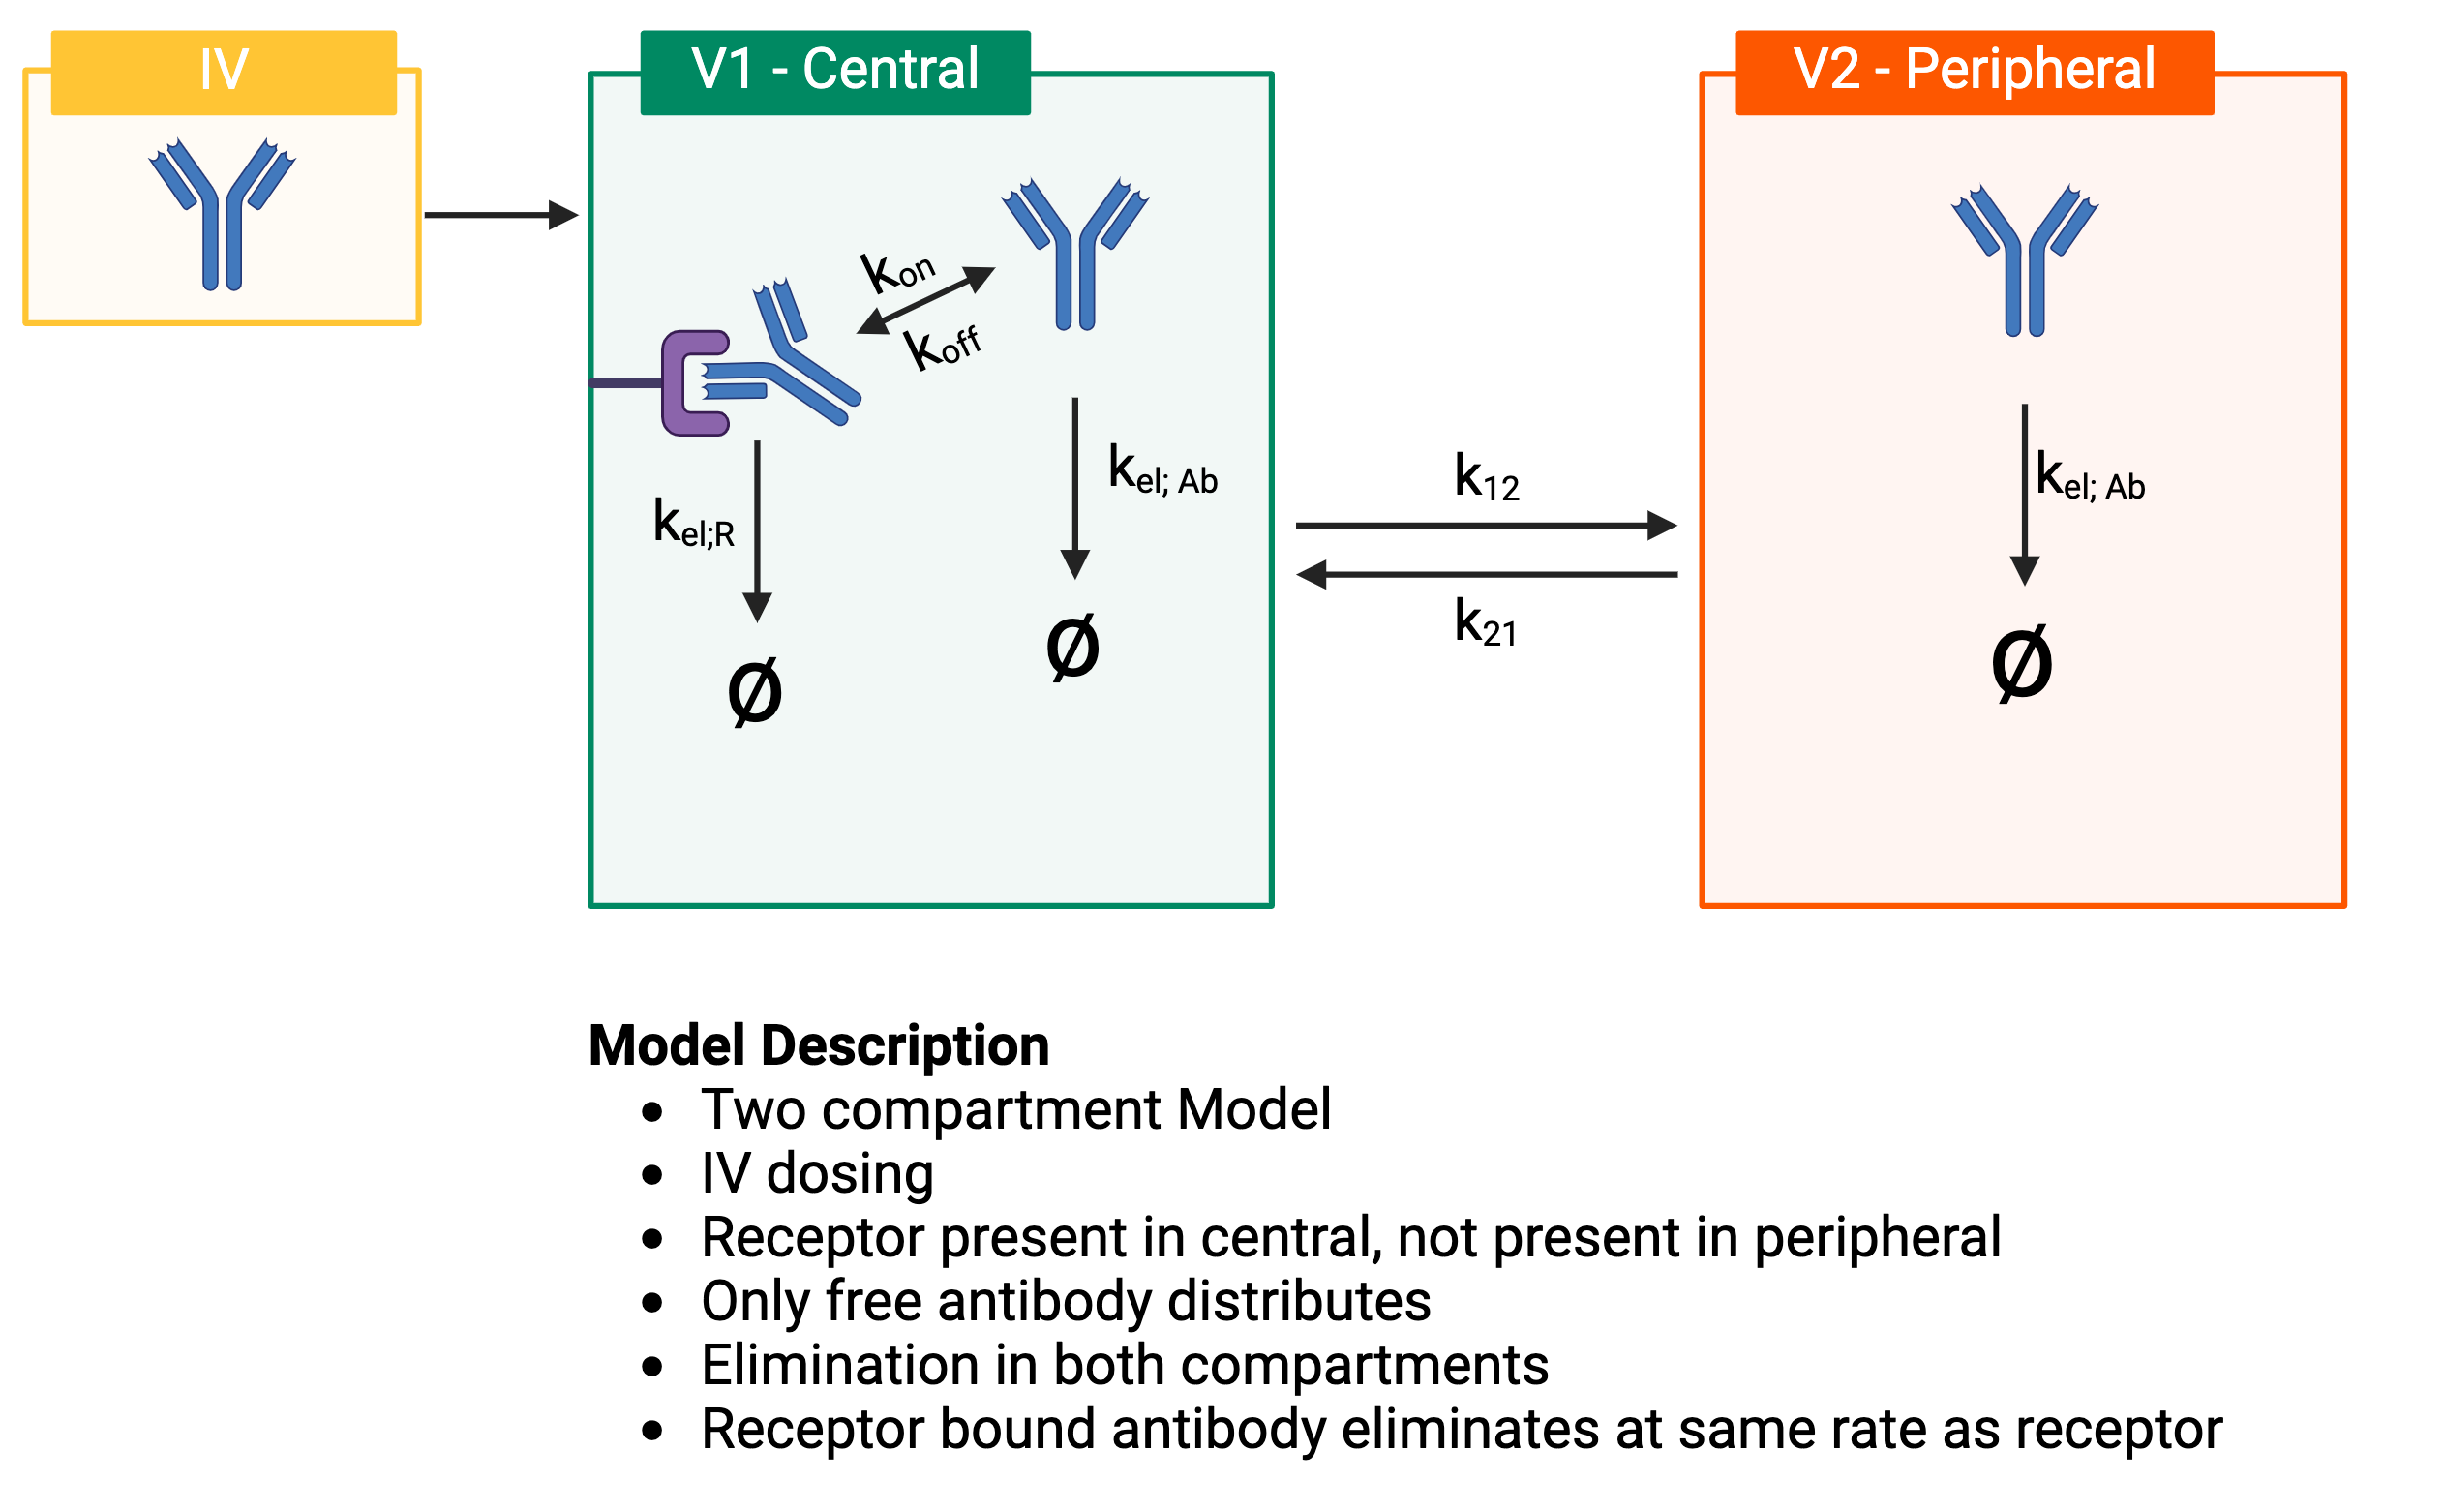
</div>


## Set up
- load `numpy`, `pandas`, `plotnine`, and `abm`

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import abm


SEC_PER_HOUR = 60*60

# 02a. Simple dose example

## Model

- Define the location of the model file as a variable named `model02a`
    - The model is located at `"../Model_Files/ModelFile02_blank"`.
    - This model file is a duplicate of the finished model file used in the QSP Introductory workshops. We will add to this model file as needed.

In [2]:
model02a = '../Model_Files/ModelFile02a_answers.model'

## Parameter table

- Load in parameter table.
  - The parameter table is found in `"../Tables/ParameterTable.csv"`

In [3]:
Tpar02a = pd.read_csv('../Tables/ParameterTable.csv')
Tpar02a.head()

,parameter,unit,value
0,volume_central,L,5.000
1,volume_peripheral,L,13.000
2,R_per_cell,1,10000.000
3,cell_per_mL,1/mL,1000000.000
4,kon,1/nM/s,0.001


## Dose table

This table defines the doses, routes, and frequency of drug delivery. There are 6 required columns

1. A label column - This is how the specific delivery condition will be named and called. In most cases, this can simply be the same as the dose so the column is often called something like "dose_mpk"
2. `route` - This column specifies which route is used for delivery. In our example, there is only one route option "IV_mpk".
3. `amounts` - This is the amount of drug to be delivered
4. `amount_unit` - The unit that the amount is listed in. This may be different from the unit defined in the model, but it must be a consistent unit type. ie if your model units are "mg/kg" you may use "g/kg" in the dose table, but you may NOT use "mg".
5. `times` - This column denotes when the dose should be applied
6. `time_unit` - This column denots the units of the time when the dose should be applied. This does not need to be the same unit as your default model file, but must be a valid time unit

We'll start with a simple example: a few single doses via IV infusion, one of which is dosed in several different schedules.

We want to create a dose table with the following doses and schedules:
* 0.01, 0.1, and 1 mg/kg single doses, each given at time 0
* 10 mg/kg dose, given 3 different ways: one dose at time 0, every 2 days for 4 total doses, or every day for 8 total doses

*NOTE:* since one of your dose amounts is the same but given 3 different schedules, a label column will be necessary to distinguish each 10 mg/kg dose, and will also be helpful for labeling in figures.

### Dose Table task
- Create a dose table with the above conditions using pandas
    - The first row is given for you
    - Include a column called `schedule` and label each schedule type (e.g. single, Q2D, etc.)

In [4]:
# we will use these doses multiple times
doses_mpk = [0.01,0.1,1,10,10,10]
schedules = ['single','single','single','single','Q2Dx4','QDx8']

Tdos02a = pd.DataFrame({
    'dose_mpk': doses_mpk,
    'route': 'IV_mpk',
    'amounts': doses_mpk,
    'amount_unit': 'mg/kg',
    'times': [[0],[0],[0],[0],list(range(0,8,2)),list(range(0,8))],
    'time_unit': 'd',
    'schedule': schedules
})

# print out the dose table to make sure it's correct
Tdos02a

,dose_mpk,route,amounts,amount_unit,times,time_unit,schedule
0,0.01,IV_mpk,0.01,mg/kg,[0],d,single
1,0.10,IV_mpk,0.10,mg/kg,[0],d,single
2,1.00,IV_mpk,1.00,mg/kg,[0],d,single
3,10.00,IV_mpk,10.00,mg/kg,[0],d,single
4,10.00,IV_mpk,10.00,mg/kg,"[0, 2, 4, 6]",d,Q2Dx4
5,10.00,IV_mpk,10.00,mg/kg,"[0, 1, 2, 3, 4, 5, 6, 7]",d,QDx8


## Simulation table
This is a table containing the same label column as the Dose Table with row entries equivalent to which specific conditions you want to simulate. If you want to simulate all the conditions in the Dose table, this will be simply the unique label rows. But if you want to simulate only a subset of these conditions, then your simulation table will be a subset of the possible label values.

### Simulation Table task
- Build a simulation table that will uniquely identify the corresponding rows in the dose table.

In [5]:
# we only need the label column to identify the corresponding rows in Tdos
Tsim02a = Tdos02a[['dose_mpk','schedule']]
Tsim02a

,dose_mpk,schedule
0,0.01,single
1,0.10,single
2,1.00,single
3,10.00,single
4,10.00,Q2Dx4
5,10.00,QDx8


## Simulate

### Simulation Task
- In the model text file, add an output of free drug called `free_drug_ngml` with unit ng/mL.
    - Apply the correct conversion to ensure the units are accurate
- Simulate 200 hours for the dose and simulation table assigned above
    - Add free drug (ng/mL) to the outputs in the simulation structure
- We created an additional column called `"label"` in the output table that combines the dose and schedule information

In [6]:
Tout02a = abm.simulate(
    simulations=Tsim02a,
    models=model02a,
    doses=Tdos02a,
    parameters=Tpar02a,
    times=abm.linspace(0,15,101,'hr').to_list() + abm.linspace(15,200,101,'hr').to_list(),
    outputs=['RO1','free_drug_ngml'],
).to_pandas(tall_outputs=True)

# a nice label for dose & schedule
Tout02a['label'] = Tout02a.apply(lambda x: f'{x.dose_mpk} ({x.schedule})', axis = 1)
Tout02a

Total: 6, Running: 0, Succeeded: 6, Failed: 0

,dose_mpk,schedule,id,t,output,value,output_unit,label
0,0.01,single,0,0.0,RO1,0.000000,1,0.01 (single)
1,0.01,single,0,0.0,free_drug_ngml,140.000000,ng/mL,0.01 (single)
2,0.01,single,0,540.0,RO1,36.719105,1,0.01 (single)
3,0.01,single,0,540.0,free_drug_ngml,138.724897,ng/mL,0.01 (single)
4,0.01,single,0,1080.0,RO1,55.562695,1,0.01 (single)
...,...,...,...,...,...,...,...,...
2419,10.00,QDx8,5,706680.0,free_drug_ngml,769610.962484,ng/mL,10.0 (QDx8)
2420,10.00,QDx8,5,713340.0,RO1,99.994281,1,10.0 (QDx8)
2421,10.00,QDx8,5,713340.0,free_drug_ngml,767297.745889,ng/mL,10.0 (QDx8)
2422,10.00,QDx8,5,720000.0,RO1,99.994265,1,10.0 (QDx8)


## Plot RO and free drug

### Plot task
- Plot RO and free drug on a log scale

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


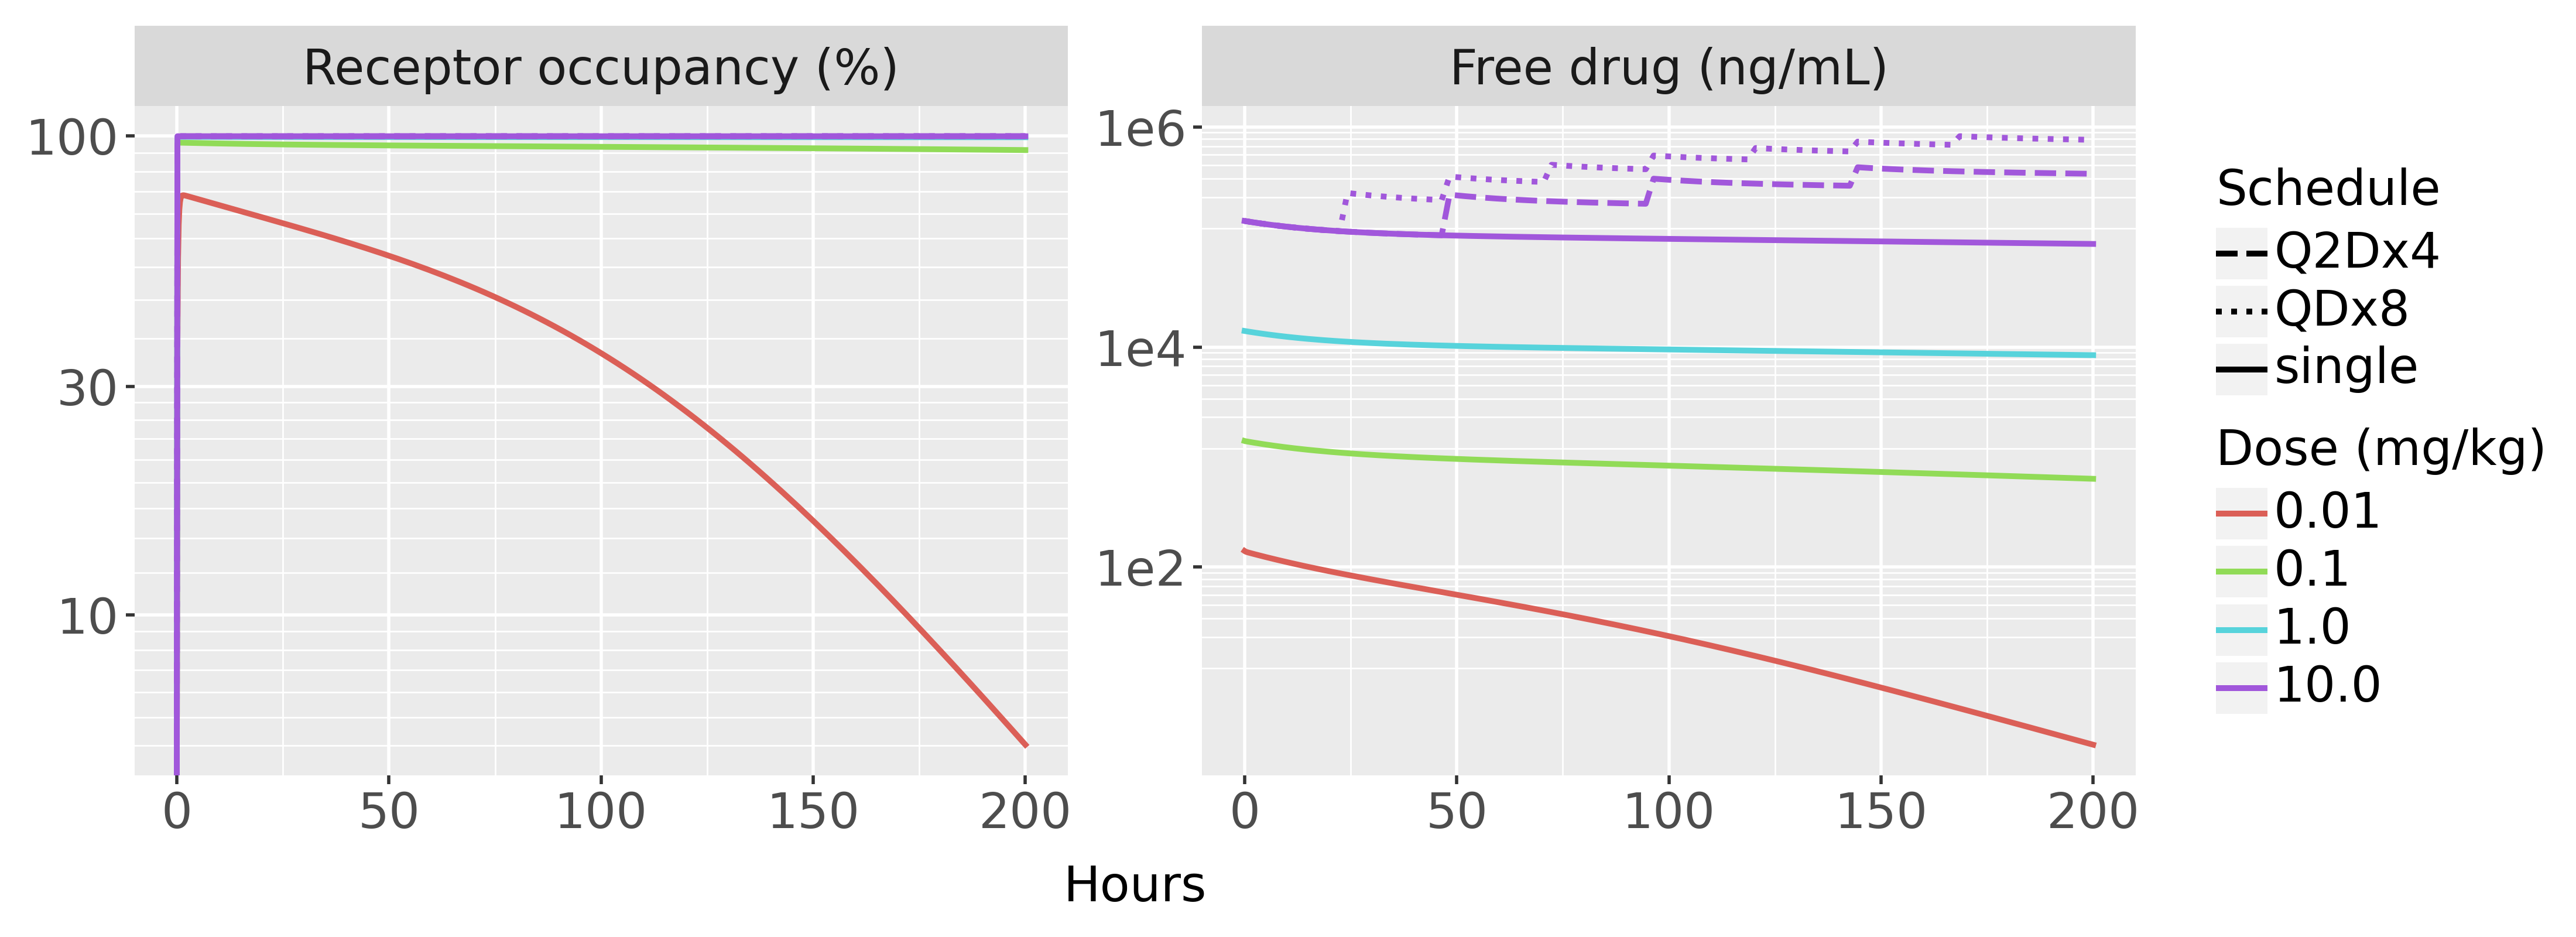

In [7]:
# alternative viewing, where linetype is used to differentiate the dose schedules

def col_func(s):
    return {'RO1': 'Receptor occupancy (%)', 'free_drug_ngml': 'Free drug (ng/mL)'}[s]

(
ggplot()
    + geom_line(Tout02a, aes('t/SEC_PER_HOUR', 'value', color='factor(dose_mpk)', linetype='schedule'), size=1)
    + labs(x='Hours', y='', color='Dose (mg/kg)', linetype='Schedule')
    + theme(figure_size = (11,4), text = element_text(size = 15), dpi=200)
    + facet_wrap('~output', scales='free_y', labeller=labeller(cols=col_func))
    + scale_linetype_manual(['--',':','-'])
    + scale_y_log10()
)

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


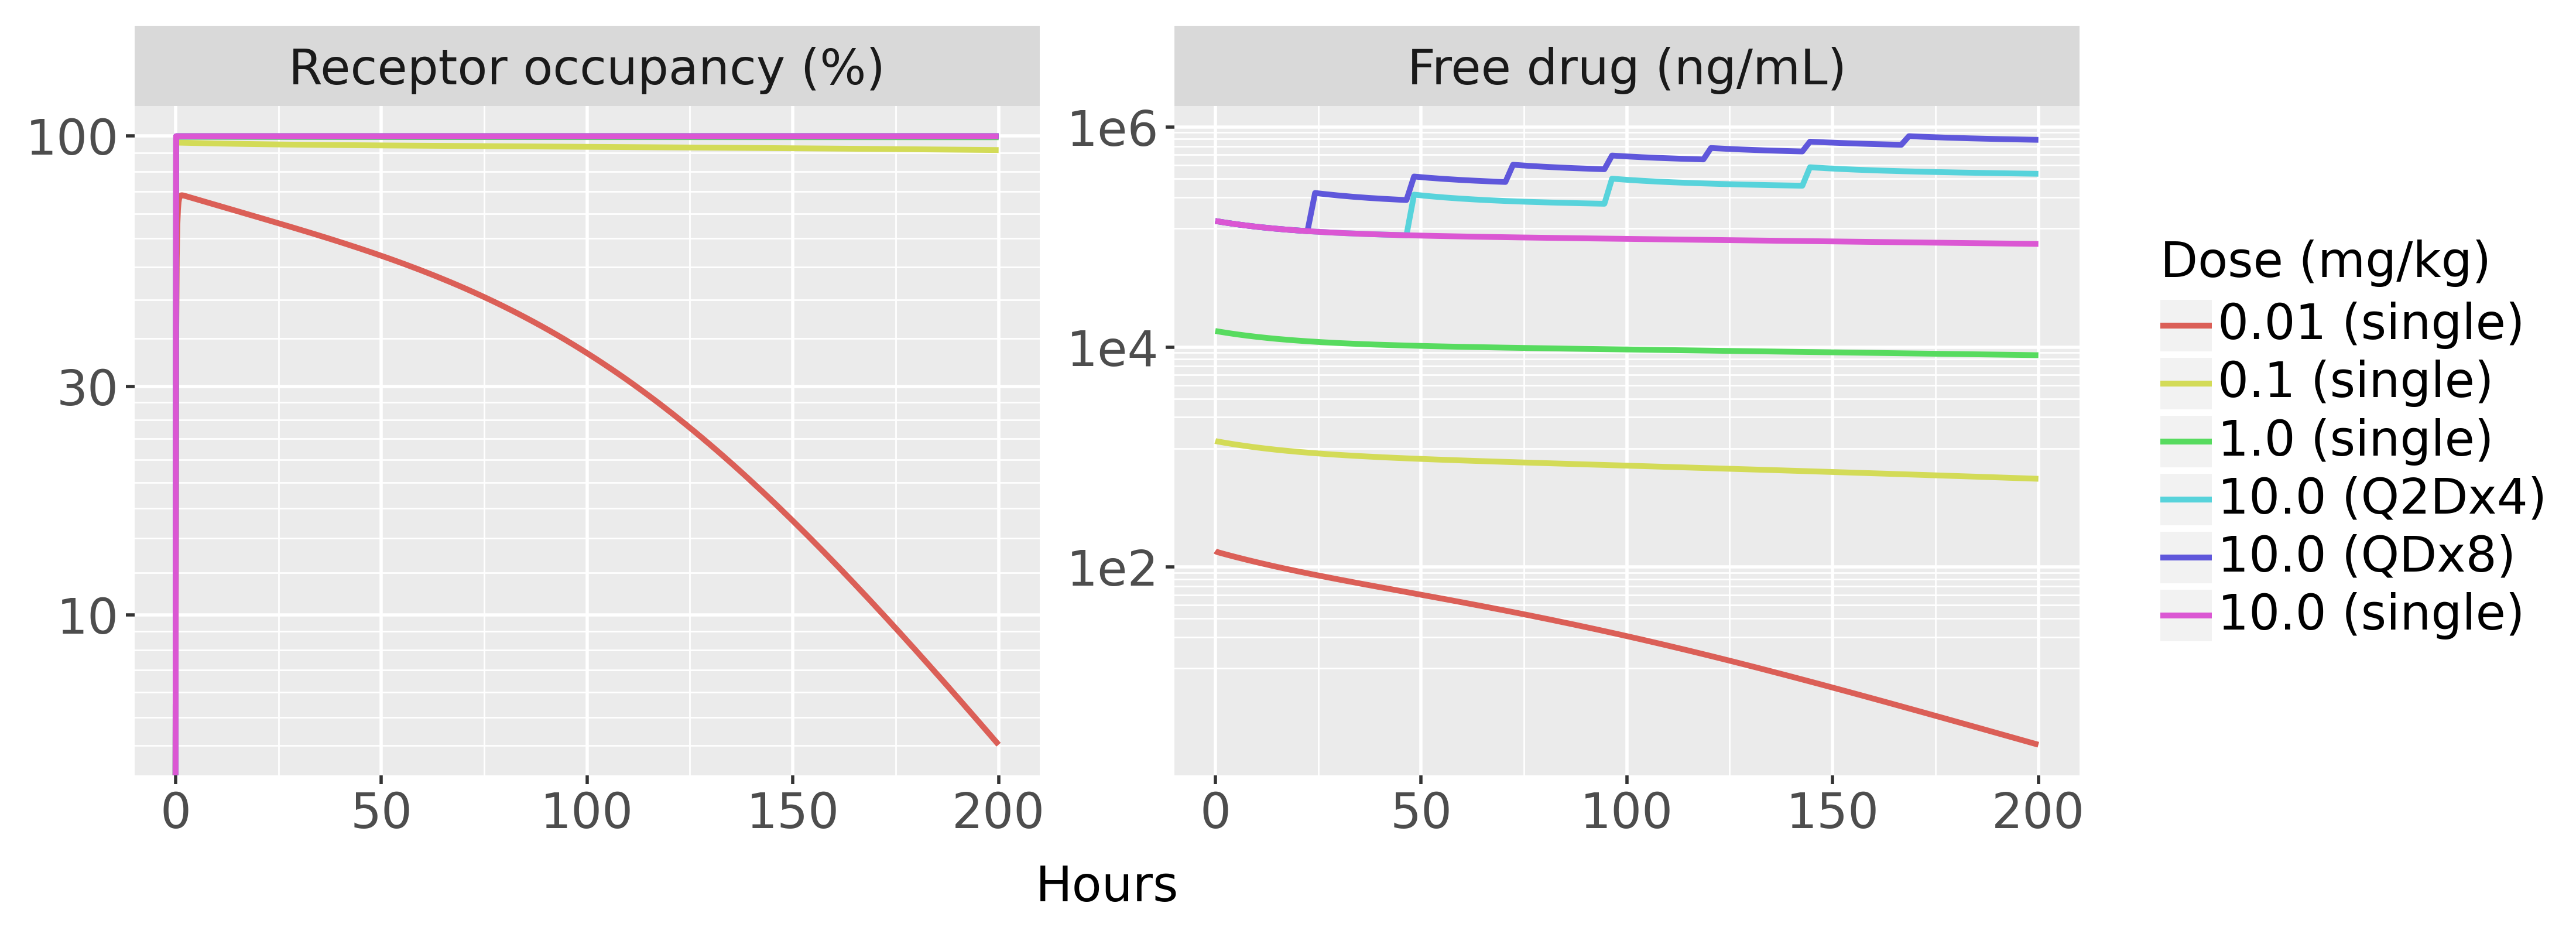

In [8]:
# create a function that maps the model outputs to a nice title for each subplot
def col_func(s):
    return {'RO1': 'Receptor occupancy (%)', 'free_drug_ngml': 'Free drug (ng/mL)'}[s]

(
ggplot()
    + geom_line(Tout02a, aes('t/SEC_PER_HOUR', 'value', color='label'), size=1)
    + labs(x='Hours', y='', color='Dose (mg/kg)')
    + theme(figure_size = (11,4), text = element_text(size = 15), dpi=200)
    + facet_wrap('~output', scales='free_y', labeller=labeller(cols=col_func))
    + scale_y_log10()
)

# 02b. New route & dose-response simulations

You are probably aware that not all drugs are dosed via IV! Subcutaneous dosing is given through injection into fatty tissue, and the body absorbs the dose more slowly. We will update both the model text file and parameter table to reflect this new route, shown in the updated model diagram below.

## Adding a new Route

### Route task
- To keep things separate, duplicate your model file and parameter table file and rename the copies to differentiate them
- add a route called `SC_mpk` and the necessary model components for subcutaneous dosing.
    - Add a new route in the line below the IV route dosing into a depot state
    - Add state and reaction for absorption
    - Update parameter table with bioavailability parameter `F_bioavail` of 0.95 and absorption rate `Thalf_abs_h` of 0.9 hours.

Try it yourself first, or see below for the text to copy and paste into the model and parameter files.
* New route: `SC_mpk: (mg/kg) = @(); drug_depot += amt * F_bioavail * (nmol_per_mol * BW) / (mg_per_g * mw)`
* New state/species: `drug_depot@central *= 0`
* New absorption reaction: `drug_depot -> Ab1_00_central; thalf = Thalf_abs_h*SECONDS_PER_HOUR`
* Parameters, values, and units:
    * `F_bioavail:1    := 0.95:1`
    * `Thalf_abs_h:hr  := 0.9:hr`

<div>
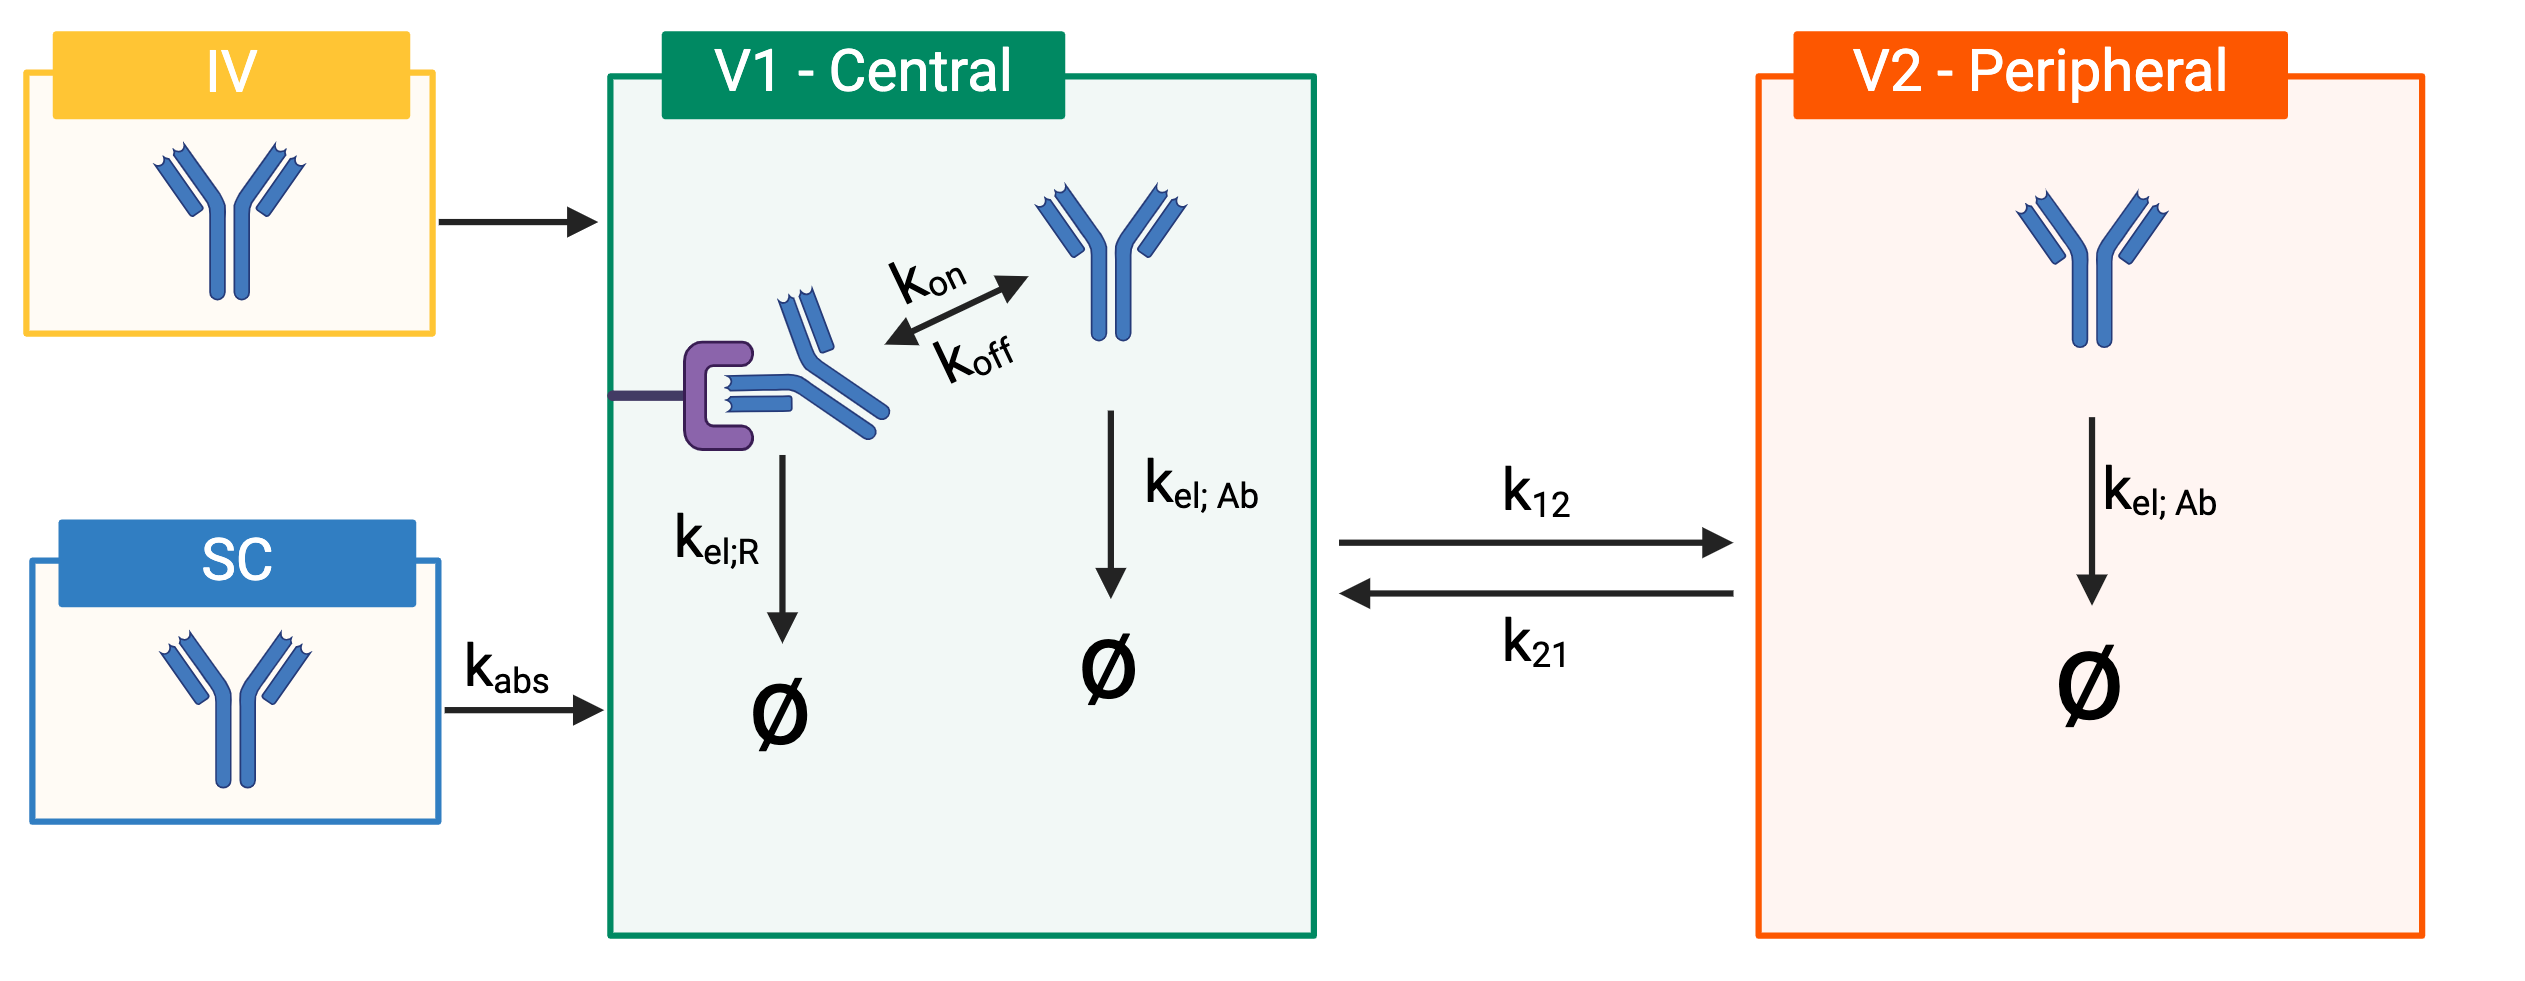
</div>

## Model

- Define a variable `model02b` to be the string to the file path of the new model file you created

In [9]:
model02b = '../Model_Files/ModelFile02b_answers.model'

## Parameter table

- Define a parameter table `Tpar02b` that reads the new parameter table you created

In [10]:
Tpar02b = pd.read_csv('../Tables/ParameterTable02b.csv')
Tpar02b

,parameter,unit,value
0,volume_central,L,5.000
1,volume_peripheral,L,13.000
2,R_per_cell,1,10000.000
3,cell_per_mL,1/mL,1000000.000
4,kon,1/nM/s,0.001
5,kd_mab,nM,0.100
6,el_half,d,28.000
7,R_half,min,60.000
8,Pdist,1,0.120
9,Tdist_hr,hr,12.000


## Dose & simulation tables

Now, we want to look at the maximum RO after 72 hours for both IV and SC dosing across all doses simulated. We want to be able to plot a dose-response curve of the extrema output.

The structure of an extrema output is as follows: `max([output of interest], start_time [s], end_time [s])`. Since we need an end time, we can either hard-code one (typically bad practice), or create a new parameter. We'll add a new parameter `t_end_h` with units of hours.

### Extrema Task

* In the model file, create an output for maximum RO over the course of the simulation: `RO1_max:1 = max(RO1, 0, t_end_h*SECONDS_PER_HOUR)`
* Add the parameter `t_end_h` to the appropriate parameter table with units `hr` and value `72`, then reload the parameter table
* Create a dose and simulation table of log-spaced doses from 0.01 to 10 mg/kg, dosed once at time 0, for both IV and SC routes

In [11]:
doses_mpk = np.logspace(-2,1,21)

# there are many ways to create this table; mine is probably not the most elegant but gets the job done. :)
Tdos02b = pd.DataFrame({
    'dose_mpk': [doses_mpk],
    'route': [['IV_mpk','SC_mpk']],
    'amount_unit': 'mg/kg',
    'times': 0,
    'time_unit': 's'
})

Tdos02b = Tdos02b.explode('dose_mpk')
Tdos02b = Tdos02b.explode('route')
Tdos02b['amounts'] = Tdos02b['dose_mpk']

Tsim02b = Tdos02b[['dose_mpk','route']]
display(Tdos02b.head())
display(Tsim02b.head())

,dose_mpk,route,amount_unit,times,time_unit,amounts
0,0.01,IV_mpk,mg/kg,0,s,0.01
0,0.01,SC_mpk,mg/kg,0,s,0.01
0,0.014125,IV_mpk,mg/kg,0,s,0.014125
0,0.014125,SC_mpk,mg/kg,0,s,0.014125
0,0.019953,IV_mpk,mg/kg,0,s,0.019953


,dose_mpk,route
0,0.01,IV_mpk
0,0.01,SC_mpk
0,0.014125,IV_mpk
0,0.014125,SC_mpk
0,0.019953,IV_mpk


## Simulate

Here, we are simulating the dose range and outputing maximum RO at 72 hours.

If we're only looking at the extrema output, we don't need to choose any particular output time. We'll arbitrarily select 72 hours to correspond with the end time parameter value.

- Simulate the maximum RO over a 72 hour window for a range of doses defined in the dose table section

In [12]:
Tout02b = abm.simulate(
    simulations=Tsim02b,
    models=model02b,
    doses=Tdos02b,
    parameters=Tpar02b,
    times=['72:hr'],
    outputs=['RO1_max'],
).to_pandas(tall_outputs=True)

Tout02b.head()

Total: 42, Running: 0, Succeeded: 42, Failed: 0

,dose_mpk,route,id,t,output,value,output_unit
0,0.010000,IV_mpk,0,259200.0,RO1_max,75.255660,1
1,0.010000,SC_mpk,1,259200.0,RO1_max,72.719835,1
2,0.014125,IV_mpk,2,259200.0,RO1_max,81.289075,1
3,0.014125,SC_mpk,3,259200.0,RO1_max,79.210277,1
4,0.019953,IV_mpk,4,259200.0,RO1_max,86.096163,1


## Plot dose-response curve

Here we will separate the different dosing routes by color.

### Figure task
- Plot the dose response curve
- Color code the response by route

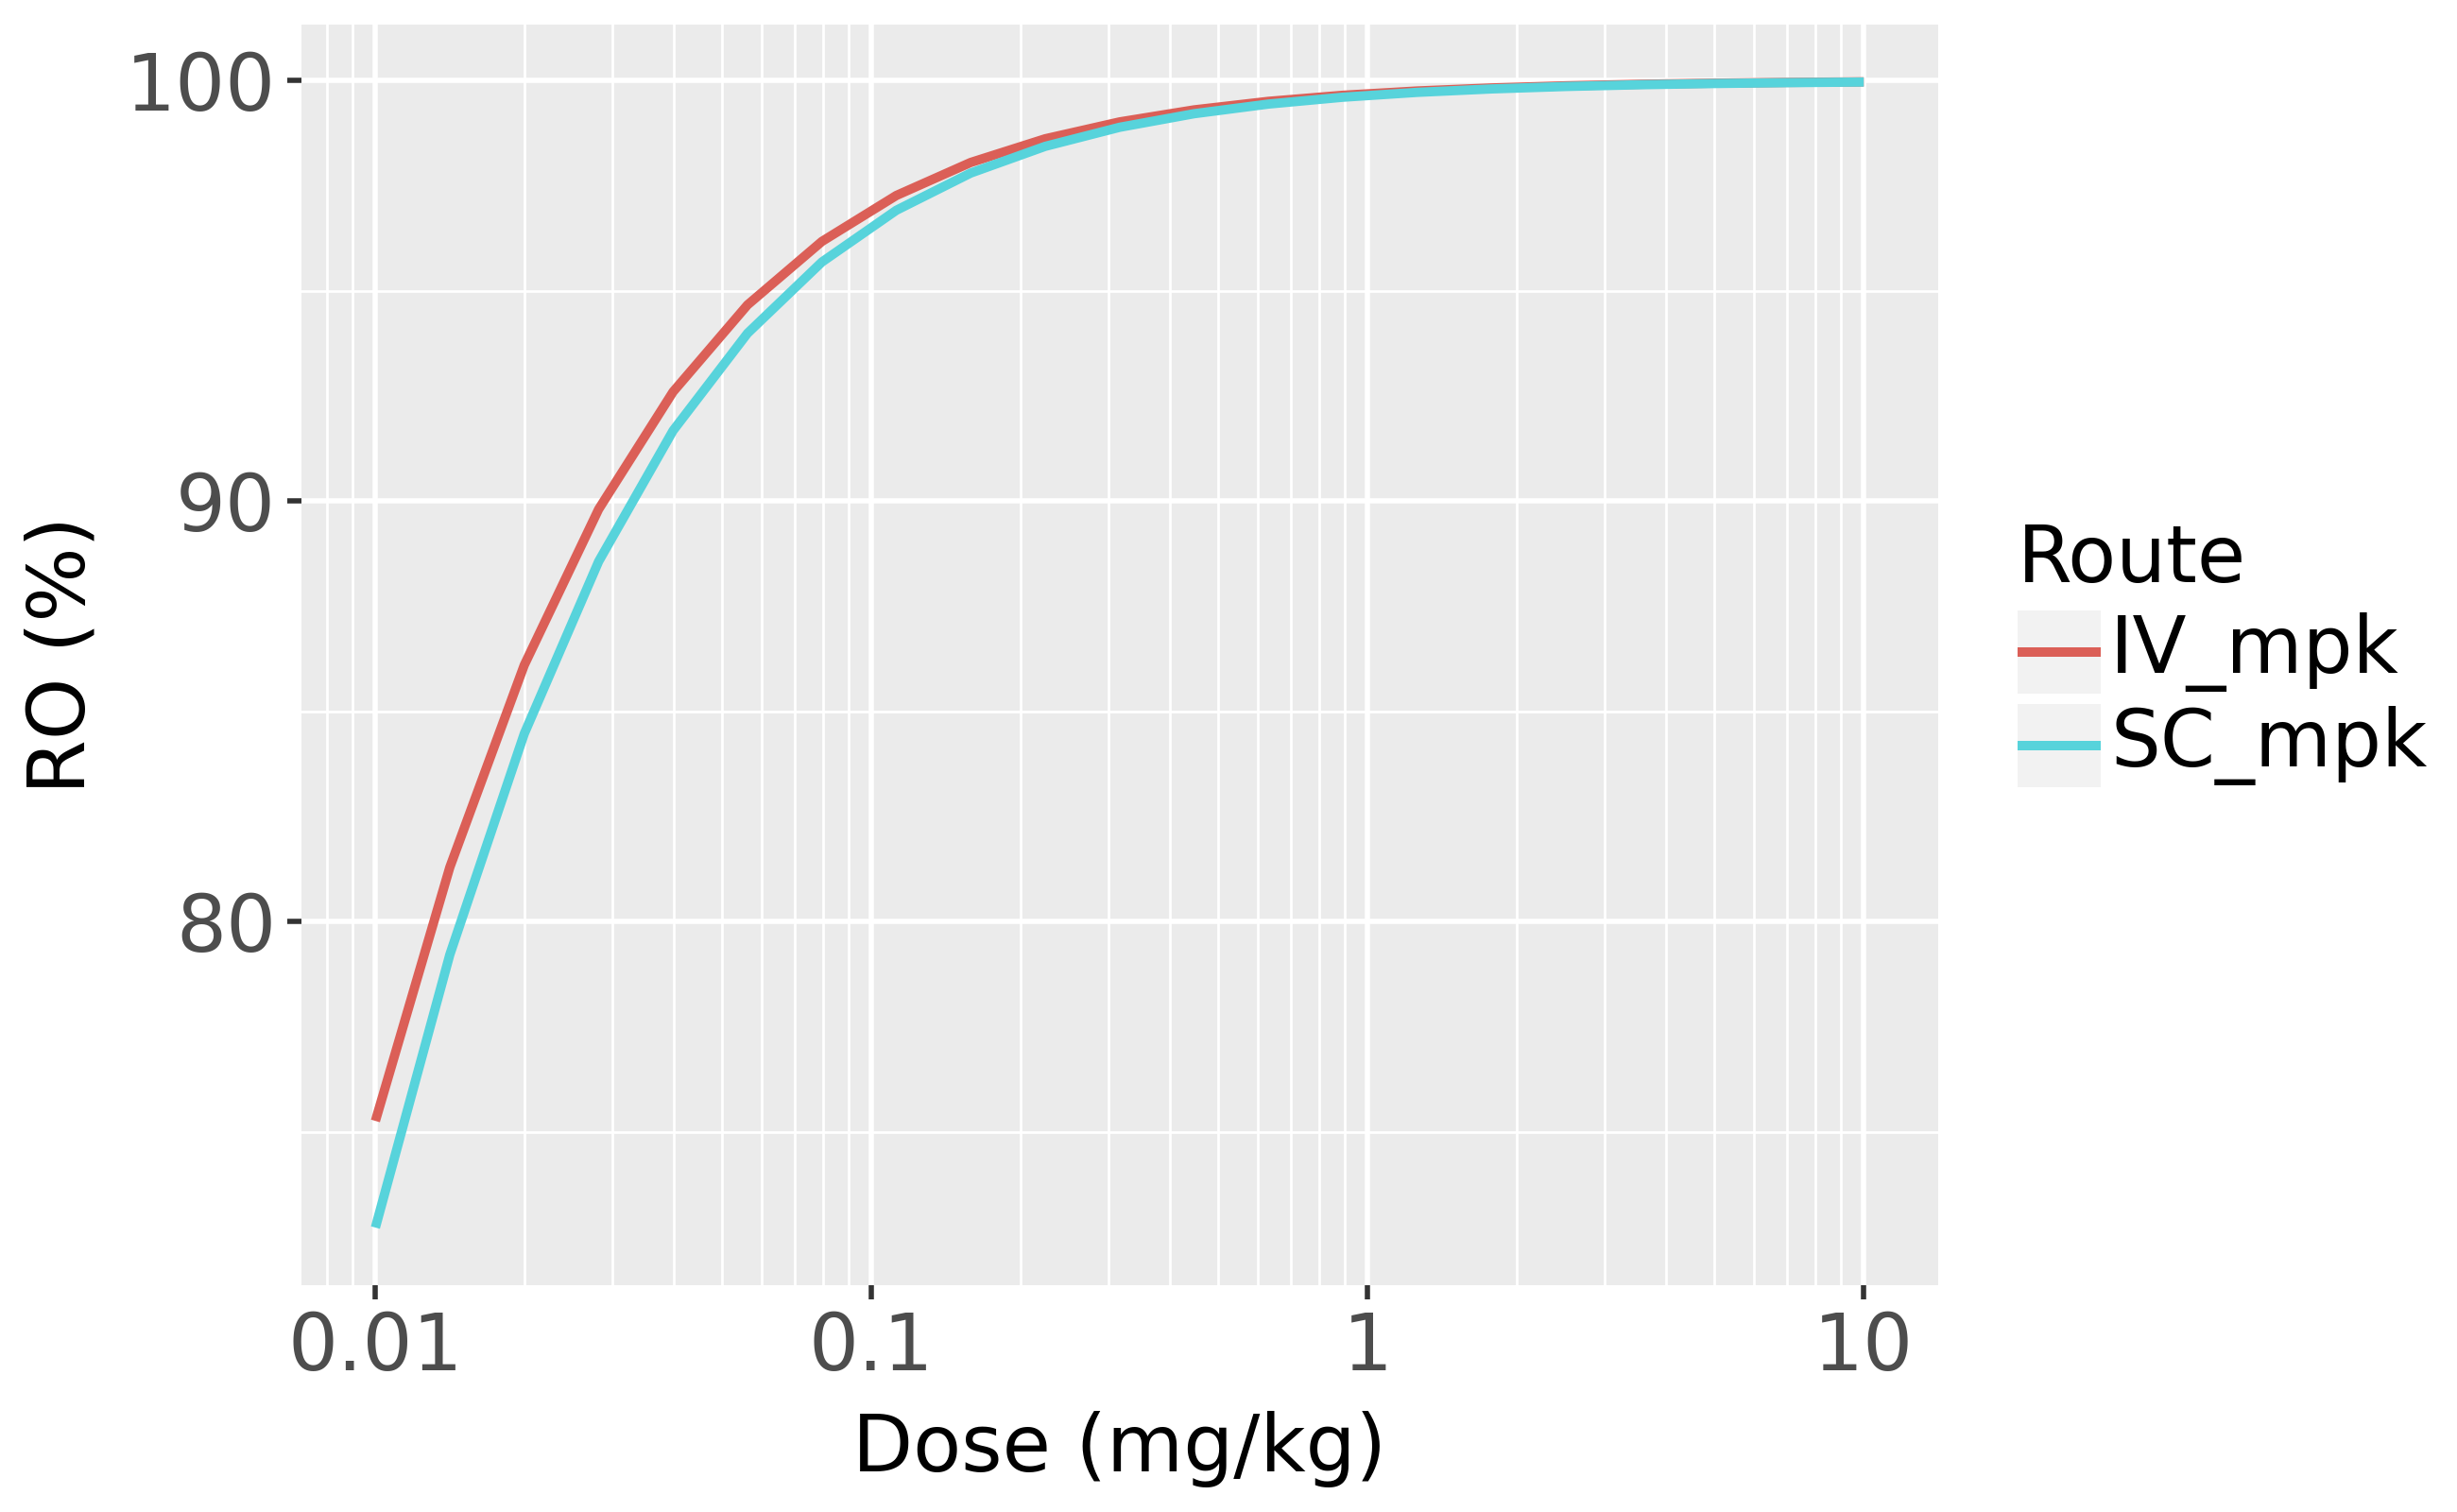

In [13]:
(
ggplot()
    + geom_line(Tout02b, aes('dose_mpk', 'value', color='route'), size=1)
    + labs(x='Dose (mg/kg)', y='RO (%)', color='Route')
    + theme(figure_size = (6.5,4), text = element_text(size = 15), dpi=200)
    # + scale_x_continuous(breaks=np.arange(0,25,6))
    + scale_x_log10()
)

# 02c. Simulating different lead candidates

A new lead candidate has the following updated parameters:
* `Pdist = 0.4`
* `Tdist_hr = 10`
* `el_half = 10`
* `F_bioavail = 0.5`
* `Thalf_abs_h = 0.85`

## Parameter Table
### Parameter table task
- Update the parameter table to reflect the parameterizations of both molecules, labeling the original parameterization `'ABS-001'` and the new one `'ABS-002'`.
    - You'll need to create a new column, which we'll label as `molecule`. For each row where the parameter stays the same across molecules, such as compartment volumes and target expression, there will have a `*` in that column.
    - Each row with a parameter that differs between molecules should be duplicated (see list above). The `molecule` label will either have `ABS-001` or `ABS-002`, and the values will be unique.

In [14]:
Tpar02c = pd.read_csv('../Tables/ParameterTable02c.csv')
Tpar02c

,molecule,parameter,unit,value
0,*,volume_central,L,5.000
1,*,volume_peripheral,L,13.000
2,*,R_per_cell,1,10000.000
3,*,cell_per_mL,1/mL,1000000.000
4,*,kon,1/nM/s,0.001
5,*,kd_mab,nM,0.100
6,ABS-001,el_half,d,28.000
7,ABS-002,el_half,d,10.000
8,*,R_half,min,60.000
9,ABS-001,Pdist,1,0.120


## Dose & simulation tables

### Dose and Simulation Table task
- Update the dose and simulation tables to simulate both molecules.
    - You'll need a new column labeled `molecule`, such that the dose range from 2b can be simulated for both the ABS-001 and ABS-002 molecules.

*Hint*: there are many ways to build this table. One way is by using `.assign(col_name = "{string}")` on a table to add a new column with all entries equal to a string.

In [15]:
Tdos02c = pd.concat([Tdos02b.assign(molecule='ABS-001'),Tdos02b.assign(molecule='ABS-002')])

Tsim02c = Tdos02c[['dose_mpk','route','molecule']]
Tdos02c

,dose_mpk,route,amount_unit,times,time_unit,amounts,molecule
0,0.01,IV_mpk,mg/kg,0,s,0.01,ABS-001
0,0.01,SC_mpk,mg/kg,0,s,0.01,ABS-001
0,0.014125,IV_mpk,mg/kg,0,s,0.014125,ABS-001
0,0.014125,SC_mpk,mg/kg,0,s,0.014125,ABS-001
0,0.019953,IV_mpk,mg/kg,0,s,0.019953,ABS-001
...,...,...,...,...,...,...,...
0,5.011872,SC_mpk,mg/kg,0,s,5.011872,ABS-002
0,7.079458,IV_mpk,mg/kg,0,s,7.079458,ABS-002
0,7.079458,SC_mpk,mg/kg,0,s,7.079458,ABS-002
0,10.0,IV_mpk,mg/kg,0,s,10.0,ABS-002


## Simulate

- Output the same as 2b: maximum RO at 72 hours, for both molecules and both dosing routes.

In [16]:
Tout02c = abm.simulate(
    simulations=Tsim02c,
    models=model02b,
    doses=Tdos02c,
    parameters=Tpar02c,
    times=['72:hr'],
    outputs=['RO1_max'],
).to_pandas(tall_outputs=True)

Tout02c.head()

Total: 84, Running: 0, Succeeded: 84, Failed: 0

,dose_mpk,route,molecule,id,t,output,value,output_unit
0,0.010000,IV_mpk,ABS-001,0,259200.0,RO1_max,75.255660,1
1,0.010000,SC_mpk,ABS-001,1,259200.0,RO1_max,72.719835,1
2,0.014125,IV_mpk,ABS-001,2,259200.0,RO1_max,81.289075,1
3,0.014125,SC_mpk,ABS-001,3,259200.0,RO1_max,79.210277,1
4,0.019953,IV_mpk,ABS-001,4,259200.0,RO1_max,86.096163,1


## Plot RO for both molecules

### Plot task
- Plot the RO maximum dose response curve
- Facet by route
- Color code and linetype code by drug name

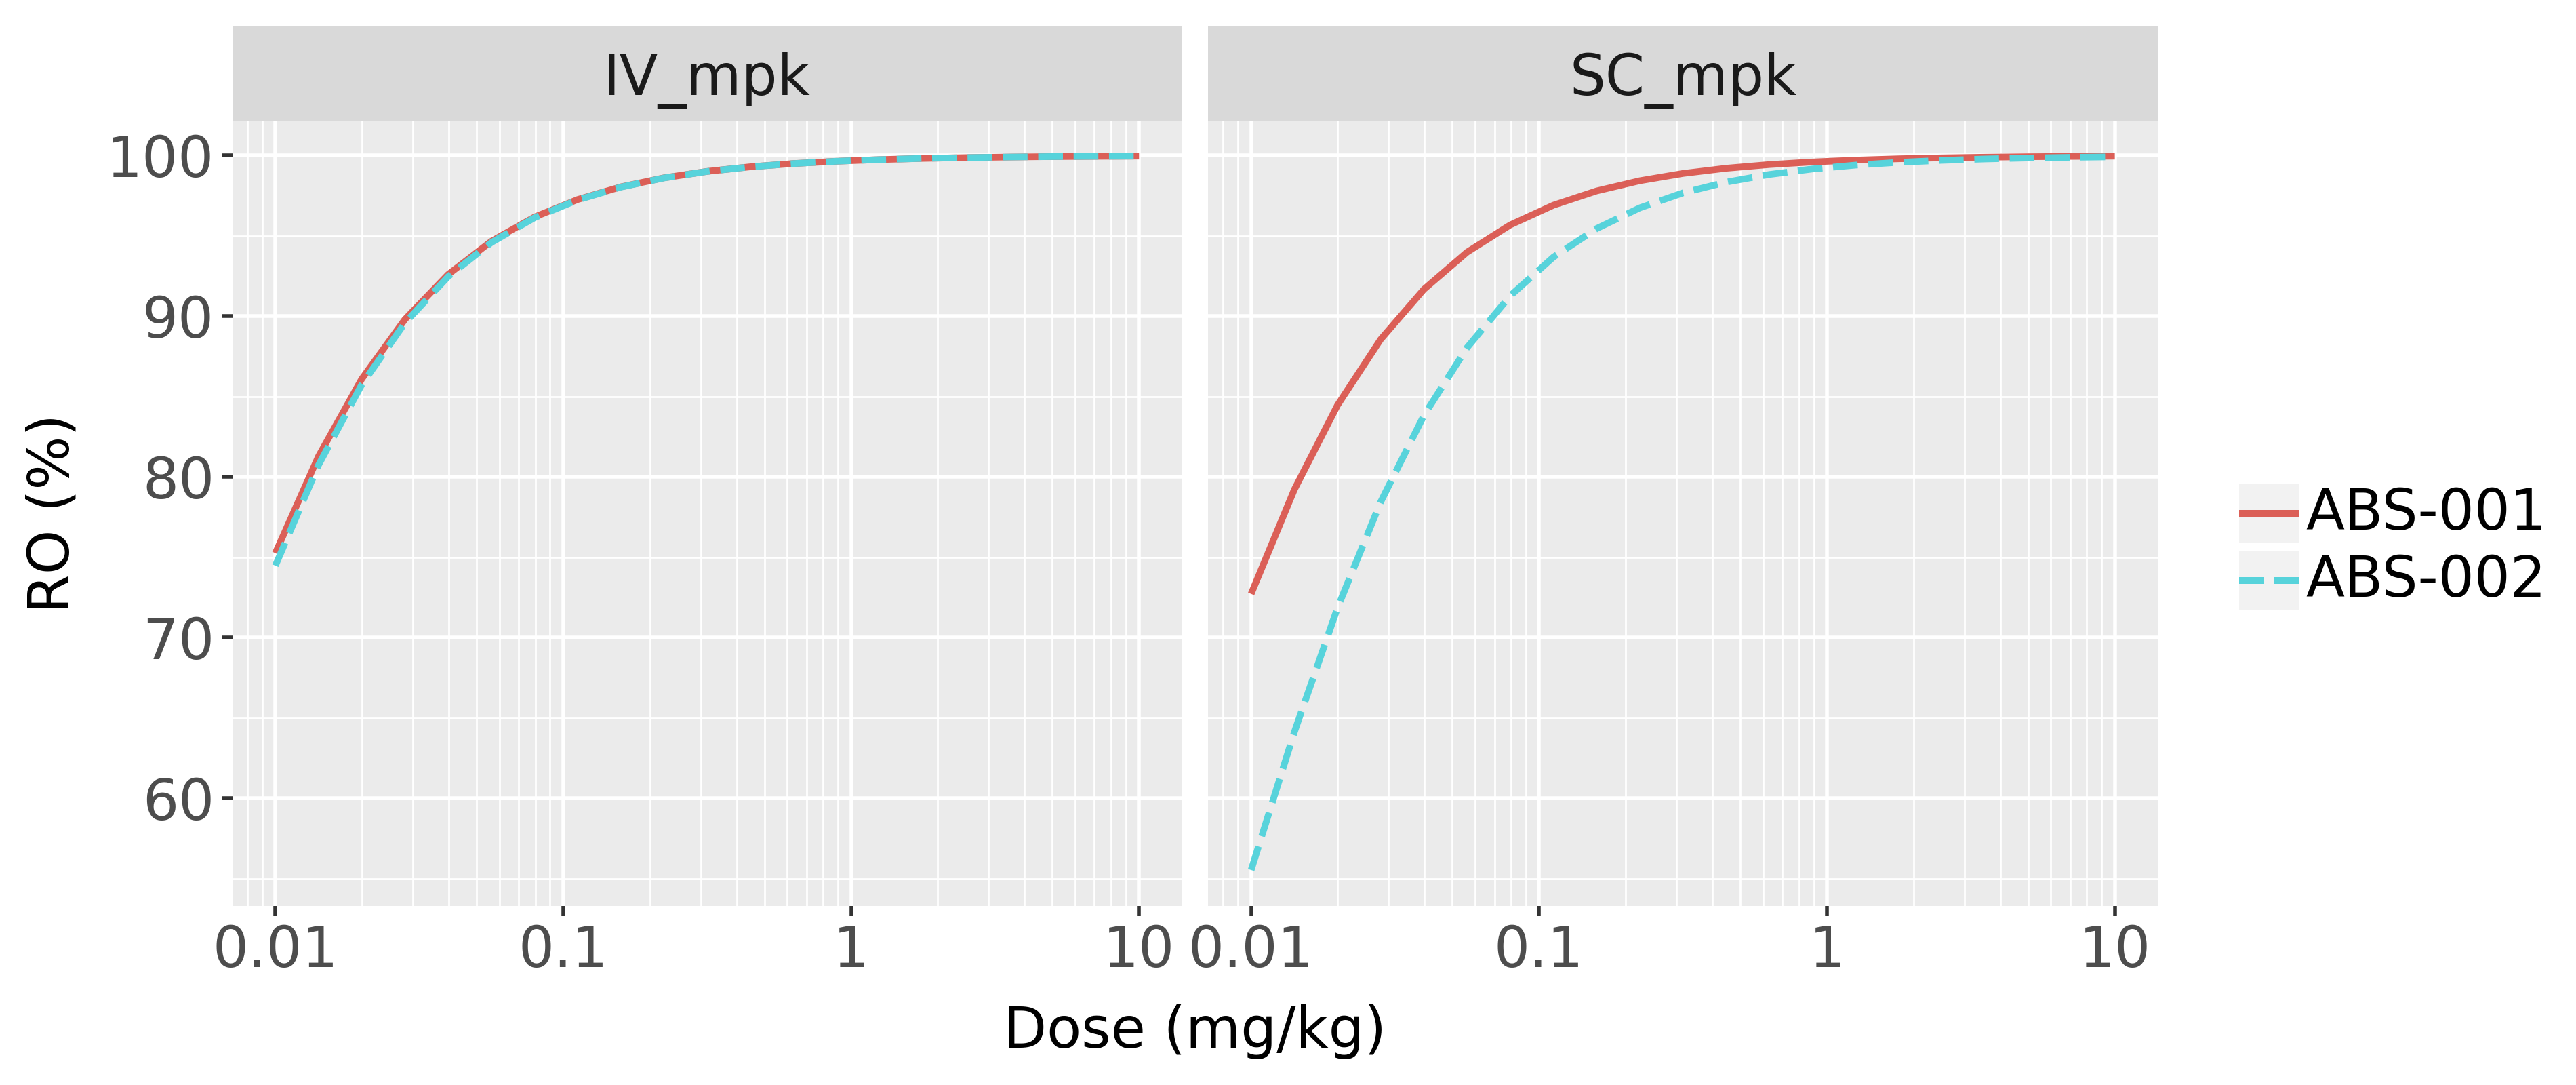

In [17]:
# here we differentiate molecule using both color and linetype for visibility purposes, since for IV the simulations overlap.
(
ggplot()
    + geom_line(Tout02c, aes('dose_mpk', 'value', color='molecule', linetype='molecule'), size=1)
    + labs(x='Dose (mg/kg)', y='RO (%)', color='', linetype='')
    + theme(figure_size = (9.5,4), text = element_text(size = 15), dpi=200)
    + facet_wrap('~route')
    # + scale_x_continuous(breaks=np.arange(0,25,6))
    + scale_x_log10()
)